# Imports

In [63]:
import argparse
import csv
import os
import random
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import os
from collections import defaultdict
import os
import csv
import torch
import torch.nn.functional as F
import os
import numpy as np
import os
import numpy as np
import torch
from torchvision import transforms
import os
from PIL import Image
import torch
import torch.nn.functional as F
import csv
import torchvision.transforms.functional as TF

# Get images and labels

In [143]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Create a dictionary to map class names to indices
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir))) if cls_name != 'websites'}
        
        num_classes = len(class_to_idx)

        # Print out the classes and how labels are set
        print("Classes and Label Encoding:")
        for class_name, class_idx in class_to_idx.items():
            label = [0] * num_classes
            label[class_idx] = 1
            print(f"Class: {class_name}, Label Encoding: {label}")

        # Traverse the root directory and collect paths of all image files
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path) and class_name != 'websites':
                class_idx = class_to_idx[class_name]  # Get the index of the current class
                for img_file in os.listdir(class_path):
                    if img_file.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_path, img_file))

                        # Initialize label list with zeros for each image
                        label = [0] * num_classes
                        
                        # Set the corresponding class index to 1
                        label[class_idx] = 1

                        # Append the one-hot encoded label to the labels list
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define the total dataset
train_dataset = PlantDataset(root_dir='../Downloading_images/data/train')
val_dataset = PlantDataset(root_dir='../Downloading_images/data/val')
test_dataset = PlantDataset(root_dir='../Downloading_images/data/test')


Classes and Label Encoding:
Class: 130228, Label Encoding: [1, 0, 0, 0, 0, 0, 0, 0]
Class: 47892, Label Encoding: [0, 1, 0, 0, 0, 0, 0, 0]
Class: 48537, Label Encoding: [0, 0, 1, 0, 0, 0, 0, 0]
Class: 48681, Label Encoding: [0, 0, 0, 1, 0, 0, 0, 0]
Class: 593040, Label Encoding: [0, 0, 0, 0, 1, 0, 0, 0]
Class: 59549, Label Encoding: [0, 0, 0, 0, 0, 1, 0, 0]
Class: 83653, Label Encoding: [0, 0, 0, 0, 0, 0, 1, 0]
Class: 914922, Label Encoding: [0, 0, 0, 0, 0, 0, 0, 1]
Classes and Label Encoding:
Class: 130228, Label Encoding: [1, 0, 0, 0, 0, 0, 0, 0]
Class: 47892, Label Encoding: [0, 1, 0, 0, 0, 0, 0, 0]
Class: 48537, Label Encoding: [0, 0, 1, 0, 0, 0, 0, 0]
Class: 48681, Label Encoding: [0, 0, 0, 1, 0, 0, 0, 0]
Class: 593040, Label Encoding: [0, 0, 0, 0, 1, 0, 0, 0]
Class: 59549, Label Encoding: [0, 0, 0, 0, 0, 1, 0, 0]
Class: 83653, Label Encoding: [0, 0, 0, 0, 0, 0, 1, 0]
Class: 914922, Label Encoding: [0, 0, 0, 0, 0, 0, 0, 1]
Classes and Label Encoding:
Class: 130228, Label Encoding:

In [144]:
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 10944
Number of images in validation dataset: 2352
Number of images in test dataset: 2352


In [110]:
print(len(train_dataset))

10944


In [111]:
train_dataset

In [112]:
from torchvision import transforms

# Define the transformation without normalization for visualization
transform_without_normalization = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    # You can remove transforms.ToTensor() here since the image is already a PIL Image
])

# Select a random index to retrieve an image
idx = 0  # You can change this to any index within the dataset length

# Retrieve the image and its label
image, label = train_dataset[idx]

# Apply the transformation without normalization to get the image in its original form
image_without_normalization = transform_without_normalization(image)

# Convert the PIL Image to a NumPy array for easy manipulation
image_np = np.array(image_without_normalization)

# Print image properties
print("Image shape:", image_np.shape)
print("Image mean:", image_np.mean())
print("Image standard deviation:", image_np.std())

# You can also visualize the image if needed
image_without_normalization.show()


Image shape: (224, 224, 3)
Image mean: 123.16761665603741
Image standard deviation: 59.89321928620733


In [113]:
print(len(val_dataset))

2352


In [114]:
print(len(test_dataset))

2352


# Make train val and test sets

- Training imagea are 70%
- Validation images are 15%
- Testing images are 15%.

### How many plant-images do we have from each class

In [115]:
# Initialize a dictionary to store the count of images for each plant
images_per_plant = {}

# Iterate through subfolders (plants) in the root directory
root_dir = 'C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data/' 
for plant_folder in os.listdir(root_dir):
    # Construct the full path to the plant folder
    plant_folder_path = os.path.join(root_dir, plant_folder)
    
    # Check if it's a directory and exclude the "websites" folder
    if os.path.isdir(plant_folder_path) and plant_folder != 'websites':
        # Count the number of images in the folder
        images_count = len(os.listdir(plant_folder_path))
        
        # Store the count in the dictionary with the plant name as the key
        images_per_plant[plant_folder] = images_count

# Create num_images_per_category based on images_per_plant
num_images_per_category = {
    '130228': images_per_plant.get('130228', 0),
    '47892': images_per_plant.get('47892', 0),
    '48537': images_per_plant.get('48537', 0),
    '59549': images_per_plant.get('59549', 0),
    '914922': images_per_plant.get('914922', 0)
}


# Print the count of images for each category
for plant, count in num_images_per_category.items():
    print(f'Number of images for {plant}: {count}')


Number of images for 130228: 1244
Number of images for 47892: 1132
Number of images for 48537: 1034
Number of images for 59549: 1422
Number of images for 914922: 1104


In [116]:
# Define the distribution of classes: based on freq of observations,
class_distribution = {
    47892: 0.3714,
    130228: 0.3025,
    914922: 0.1638,
    59549: 0.0658,
    48537: 0.0338,
}

# Labels

In [117]:
'''
# Initialize a set to store unique labels
unique_labels = set()

# Initialize a dictionary to store label mappings
label_map = {}

# Root directory containing subfolders (taxon IDs)
root_dir = '../Downloading_images/data/train'

# Iterate over each subfolder (taxon ID) in the root directory
for taxon_id in os.listdir(root_dir):
    # Check if the entry is a directory and exclude 'websites' folder
    if os.path.isdir(os.path.join(root_dir, taxon_id)) and taxon_id != 'websites':
        # Add the taxon ID (subfolder name) to the set of unique labels
        unique_labels.add(taxon_id)
        # Add the taxon ID (subfolder name) to the label mapping with a numerical identifier
        label_map[int(taxon_id)] = taxon_id  # You can adjust this based on your actual labels

# Calculate the number of unique classes
num_classes = len(unique_labels)

# Print the unique plant names (taxon IDs) and number of unique classes
print("Unique Plant Names (Taxon IDs):", unique_labels)
print("Number of Unique Classes:", num_classes)

# Print the label mapping
print("Label Mapping (Numerical Identifier -> Plant Name/Taxon ID):", label_map)
'''

'\n# Initialize a set to store unique labels\nunique_labels = set()\n\n# Initialize a dictionary to store label mappings\nlabel_map = {}\n\n# Root directory containing subfolders (taxon IDs)\nroot_dir = \'../Downloading_images/data/train\'\n\n# Iterate over each subfolder (taxon ID) in the root directory\nfor taxon_id in os.listdir(root_dir):\n    # Check if the entry is a directory and exclude \'websites\' folder\n    if os.path.isdir(os.path.join(root_dir, taxon_id)) and taxon_id != \'websites\':\n        # Add the taxon ID (subfolder name) to the set of unique labels\n        unique_labels.add(taxon_id)\n        # Add the taxon ID (subfolder name) to the label mapping with a numerical identifier\n        label_map[int(taxon_id)] = taxon_id  # You can adjust this based on your actual labels\n\n# Calculate the number of unique classes\nnum_classes = len(unique_labels)\n\n# Print the unique plant names (taxon IDs) and number of unique classes\nprint("Unique Plant Names (Taxon IDs):", u

In [118]:
# Find the category with the fewest images
min_category = min(num_images_per_category, key=num_images_per_category.get)

# Get the count of images for the category with the fewest images
min_count = num_images_per_category[min_category]

print(f"The category '{min_category}' has the fewest images with {min_count} images.")

The category '48537' has the fewest images with 1034 images.


In [119]:
# Define your image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [120]:
# Define batch size
batch_size = 32

In [121]:
def custom_collate(batch):
    images, labels = zip(*batch)
    images = [transform(img) for img in images]  # Apply transform to each PIL Image
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

In [122]:
# Create DataLoader with custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

In [123]:
# Create DataLoader with custom collate function
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

In [124]:
# Create DataLoader with custom collate function
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

# Setup classifier

In [125]:
# great paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8747718/ 

## Setup the model architecture

In [126]:
''' very advanced model
class PlantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantClassifier, self).__init__()
        # Define convolutional blocks
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 64 * 28 * 28)  # Adjust based on final feature map size
        # Pass through fully connected layer
        out = self.fc(x)
        return out

# Load pre-trained VGG16 model
vgg16 = models.vgg16()

# Modify the fully connected layer for plant classification
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Optionally freeze pre-trained layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

# Define your own classifier and its optimizer and loss function
model = PlantClassifier(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Combine VGG16 convolutional base with your custom classifier
class CombinedModel(nn.Module):
    def __init__(self, vgg, custom_classifier):
        super(CombinedModel, self).__init__()
        self.vgg = vgg.features  # Only taking the convolutional layers
        self.custom_classifier = custom_classifier

    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        x = self.custom_classifier(x)
        return x

# Instantiate the combined model
combined_model = CombinedModel(vgg16, model)

# Define optimizer and loss function for the combined model
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
'''

' very advanced model\nclass PlantClassifier(nn.Module):\n    def __init__(self, num_classes):\n        super(PlantClassifier, self).__init__()\n        # Define convolutional blocks\n        self.conv_block = nn.Sequential(\n            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        # Define fully connected layers\n        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size\n\n    def forward(self, x):\n        # Forward pass through convolutional blocks\n        x = self.conv_bloc

In [146]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 56 * 56, num_classes) 

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc(x)
        return x

class SimpleModel(nn.Module):
    def __init__(self, num_classes):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = SimpleModel(8)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

### Architecture:
- The convolutional blocks consist of three convolutional layers, 
each followed by a ReLU activation and a max pooling layer. 
- This helps in extracting hierarchical features from the input images.
-The output feature maps are downsampled through max pooling layers, 
ensuring consistent output shapes regardless of the input size.
- The fully connected layer's input size is adjusted based on the final 
feature map size after downsampling.

# Run the training loop

In [147]:
learning_rate = 0.2

# Apply dropout regularization
dropout_rate = 1  
model_dropout = nn.Sequential(
    nn.Dropout(dropout_rate),
    model
)

# Apply L2 regularization (weight decay)
weight_decay = 2  
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [148]:
# Define the number of epochs and early stopping parameters
num_epochs = 25
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the directory where the models and losses will be saved
models_directory = "./models/"

# Ensure the directory exists, create it if it doesn't
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Define the filename for the CSV file containing the losses
losses_file = f"./models/first_losses.csv"

# Open the file in write mode ('w') with newline='' to prevent extra newline characters
with open(losses_file, 'w', newline='') as file:
    # Create a CSV writer object
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(['Epoch', 'Train Loss', 'Val Loss'])

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        for images, _ in train_dataloader:
            optimizer.zero_grad()
            
            # Try to load images, skip if there's an error
            try:
                outputs = model(images)
            except Exception as e:
                if "cannot identify image file" in str(e):
                    print(f"Skipping image due to error: {e}")
                    continue
                else:
                    raise  # Re-raise the exception if it's not the expected one
            
            label_value = 0  # or any other label you want to assign
            labels = torch.full((images.size(0),), label_value, dtype=torch.long)

            loss = F.cross_entropy(outputs, labels)
            train_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)

            loss.backward()
            optimizer.step()

        # Calculate average training loss and accuracy
        train_loss /= len(train_dataloader)
        train_accuracy = correct_train_predictions / total_train_predictions

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for images, _ in val_dataloader:
                outputs = model(images)
                
                # For simplicity, let's assume the label for all images is 0
                labels = torch.zeros(images.size(0), dtype=torch.long)  # Batch size number of zeros
                
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()
                total_val_predictions += labels.size(0)

        # Calculate average validation loss and accuracy
        val_loss /= len(val_dataloader)
        val_accuracy = correct_val_predictions / total_val_predictions

        # Save training and validation losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save training and validation losses to the CSV file
        writer.writerow([epoch, train_loss, val_loss])

        # Check for early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Save the trained model in the "./models" folder
        torch.save(model.state_dict(), f"./models/first_model.pth")       

        # Print training and validation loss and accuracy
        print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 0, Training Loss: 24.7596, Validation Loss: 0.0017, Training Accuracy: 0.9906, Validation Accuracy: 1.0000


KeyboardInterrupt: 

## Loss curve & accuracy curve

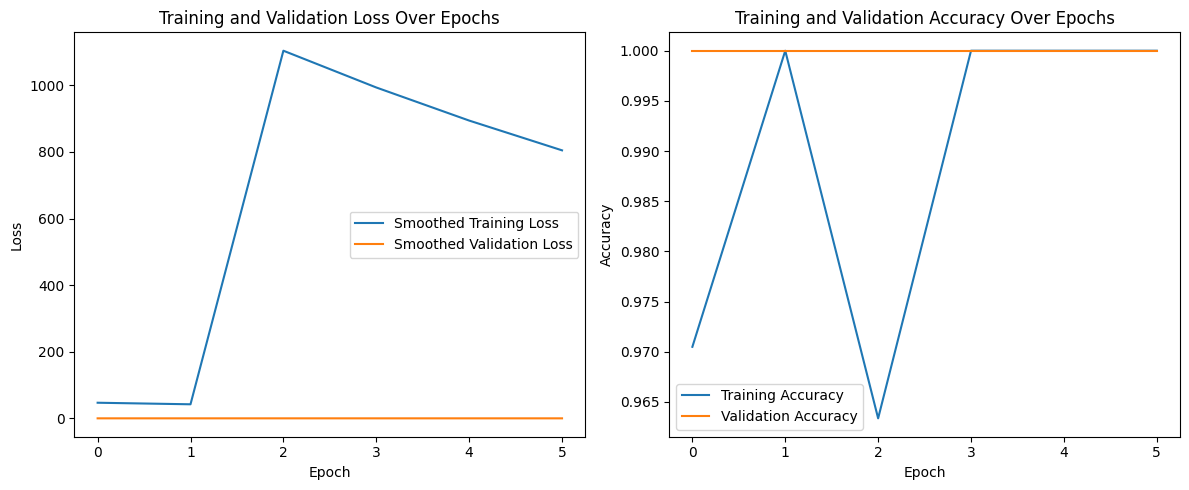

In [135]:
# Optional: Smoothing the loss curves for better visualization
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_train_losses = smooth_curve(train_losses)
smooth_val_losses = smooth_curve(val_losses)

# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_train_losses, label='Smoothed Training Loss')
plt.plot(smooth_val_losses, label='Smoothed Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [130]:
# Testing phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_dataloader:  # Assuming you have a separate test dataloader
        outputs = model(images)

        # For simplicity, let's assume the label for all images is 0
        labels = torch.zeros(images.size(0), dtype=torch.long)  # Batch size number of zeros
        
        # Calculate loss
        # Ensure labels are converted to tensors if needed
        # Assuming labels are already tensors, but if not, you can convert them like this:
        # labels = torch.tensor(labels, dtype=torch.long)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average test loss
test_loss /= len(test_dataloader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print test loss and accuracy
print(f'Test Loss: {test_loss}, Accuracy: {accuracy * 100:.2f}%')


Test Loss: 0.0, Accuracy: 100.00%


In [138]:
# Load the saved model
state_dict = torch.load('./models/first_model.pth')  # Load the state dictionary

# Instantiate your model
model = SimpleCNN()

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Define transformations for preprocessing the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of the model
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load and preprocess the image
# image_path = './images/test_image.jpg'
image_path = './images/Spiraea.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension

# Set the model to evaluation mode
model.eval()

# Pass the image through the model
with torch.no_grad():
    outputs = model(image)

# Apply softmax activation to get probabilities
probabilities = torch.nn.functional.softmax(outputs, dim=1)

# Convert probabilities to percentages
probabilities = probabilities.squeeze().numpy() * 100

# Print the probability estimates for each class
for i, probability in enumerate(probabilities):
    print(f'Class {i}: {probability:.2f}%')


Class 0: 100.00%
Class 1: 0.00%
Class 2: 0.00%
Class 3: 0.00%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%
Class 7: 0.00%


In [139]:
# Load and preprocess the image
image_path = './images/Spiraea.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  # Add batch dimension


In [140]:
print("Image shape after preprocessing:", image.shape)


Image shape after preprocessing: torch.Size([1, 3, 224, 224])


In [136]:
'''

Impatiens glandulifera
Blomsterlupin
Link
47892

Heracleum mantegazzianum
Sandlupin
Link
130228

Reynoutria japonica
Parkslide
Link
914922

Lupinus polyphyllus
Jätteslide
Link
59549

Lysichiton americanus
Hybridslide
Link
48537

Rosa rugosa
Kaukasiskt fetblad
Link
83653

Reynoutria sachalinensis
Sibiriskt fetblad
Link
593040

Spiraea
Spärroxbär
Link
48681

'''

'\nClasses and Label Encoding:\nClass: 130228, Label Encoding: [1, 0, 0, 0, 0, 0, 0, 0]\nClass: 47892, Label Encoding: [0, 1, 0, 0, 0, 0, 0, 0]\nClass: 48537, Label Encoding: [0, 0, 1, 0, 0, 0, 0, 0]\nClass: 48681, Label Encoding: [0, 0, 0, 1, 0, 0, 0, 0]\nClass: 593040, Label Encoding: [0, 0, 0, 0, 1, 0, 0, 0]\nClass: 59549, Label Encoding: [0, 0, 0, 0, 0, 1, 0, 0]\nClass: 83653, Label Encoding: [0, 0, 0, 0, 0, 0, 1, 0]\nClass: 914922, Label Encoding: [0, 0, 0, 0, 0, 0, 0, 1]\n'

# Decomposition of Images

## Feature Extraction:

### Texture Analysis: 
Extract texture features from the images to capture patterns and structures present in different regions of the plants.<br> 
local binary patterns (LBP) for characterizing plant textures.<br> 

### Color Features: 
Since your images are RGB, you can extract color features to represent the color distribution of different plant parts. <br> 
This could involve techniques such as color histograms, color moments, or color channel statistics (mean, variance, etc.).<br> 

### Shape and Structure Features: 
Extract features related to the shape and structure of plants. <br> 
This could include features like shape descriptors (e.g., Hu moments, Fourier descriptors), <br> 
morphological features (e.g., area, perimeter, compactness), or structural features (e.g., skeletonization, contour analysis).<br> 

### Deep Learning-based Features: 
Utilize pre-trained deep learning models (e.g., convolutional neural networks) <br> 
for feature extraction. You can use models like VGG, ResNet, or MobileNet to extract high-level <br> 
features from the images, either by using the activations of intermediate layers as features or <br> 
by fine-tuning the model for your specific task.<br> 

## Integration with Bayesian Modeling:
Once you've extracted relevant features from the images, integrate them into your Bayesian modeling framework.<br> 
Assign hierarchical Bayesian priors to these extracted features <br> 
to capture their relationships and variability across different plant species or conditions.<br> 
Model the segmentation task using these features, either by directly incorporating them into <br> 
your segmentation model or by using them as inputs to guide the segmentation process.<br> 

## Inference and Segmentation:
Develop a statistical framework for inferring the posterior distributions <br> 
of the explainable variables (e.g., segmentation masks) based on <br> 
the observed data (images) and the extracted features.<br> 

Utilize Bayesian inference techniques to update the posterior distributions iteratively, <br> 
taking into account both the observed data and prior knowledge encoded in the Bayesian priors.<br> 
Segment the images into meaningful regions or features based on the inferred posterior <br> 
distributions, using techniques such as thresholding, clustering, or region-growing algorithms.<br> 

In [50]:

# Define parameters for LBP computation
radius = 1
num_points = 8 * radius

# Path to the directory containing your images
dataset_directory = 'C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data/'

# Select one image for testing (change the folder and file names as needed)
test_image_path = os.path.join(dataset_directory, 'train', '234523', 'example_image.jpg')

# Load the test image
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Compute LBP for the test image
lbp_image = cv2.LBP(test_image, radius, num_points, cv2.LBP_UNIFORM)

# Display the original and LBP images for visual inspection
cv2.imshow('Original Image', test_image)
cv2.imshow('LBP Image', lbp_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


NameError: name 'cv2' is not defined

In [ ]:
'''
# Define parameters for LBP computation
radius = 1
num_points = 8 * radius

# Path to the directory containing your images
dataset_directory = 'C:/Users/asche/OneDrive/Skrivebord/invasive_plant_classifier/Downloading_images/data/'

# List to store LBP features for all images
all_lbp_features = []

# Loop through each subfolder in the dataset directory
for root, dirs, files in os.walk(dataset_directory):
    for dir in dirs:
        # Check if the subfolder contains image files
        image_folder = os.path.join(root, dir)
        if len(os.listdir(image_folder)) == 0:
            continue  # Skip empty folders
        
        # Loop through each image file in the subfolder
        for filename in os.listdir(image_folder):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust file extensions as needed
                # Load the image
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Compute LBP for the image
                lbp = cv2.LBP(image, radius, num_points, cv2.LBP_UNIFORM)
                all_lbp_features.append(lbp)

# Convert the list of features to a numpy array
all_lbp_features = np.array(all_lbp_features)

# Now you have the LBP features for all images in your dataset
print("Shape of LBP features array:", all_lbp_features.shape)
'''